# Araç Fiyat Tahmin Modeli - Model Eğitimi

Bu notebook, temizlenmiş veri üzerinde CatBoost modeli eğitir ve değerlendirir.

## İçerik
1. Kütüphanelerin Yüklenmesi
2. Veri Yükleme ve Hazırlama
3. Özellik Seçimi
4. Train/Test Bölme
5. Baseline Model
6. Hiperparametre Optimizasyonu (Optuna)
7. Final Model Eğitimi
8. Öğrenme Eğrileri
9. Model Değerlendirme
10. Özellik Önem Analizi
11. Cross-Validation
12. Model Kaydetme

## 1. Kütüphanelerin Yüklenmesi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

# Hiperparametre optimizasyonu için
try:
    import optuna
    OPTUNA_AVAILABLE = True
    optuna.logging.set_verbosity(optuna.logging.WARNING)
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna yüklü değil. Hiperparametre optimizasyonu atlanacak.")
    print("Yüklemek için: pip install optuna")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Kütüphaneler başarıyla yüklendi!")
print(f"Optuna: {'Mevcut' if OPTUNA_AVAILABLE else 'Yok'}")

Kütüphaneler başarıyla yüklendi!
Optuna:  Mevcut


## 2. Veri Yükleme ve Hazırlama

In [2]:
# Temizlenmiş veriyi yükle
df = pd.read_csv('../outputs/cleaned_data.csv')

print(f"Veri boyutu: {df.shape[0]:,} satır, {df.shape[1]} sütun")
print(f"
Sütunlar:")
print(df.columns.tolist())

Veri boyutu: 6,671 satır, 31 sütun

Sütunlar:
['il', 'fiyat(TRY)', 'marka', 'seri', 'model', 'kilometre(Km)', 'yıl', 'vitesTipi', 'yakitTuru', 'kasaTipi', 'renk', 'cekisTipi', 'takasUygunluk', 'saticiTuru', 'hasarGecmisi', 'orjinal_parça_sayısı', 'lokal_boyalı_parça_sayısı', 'boyalı_parça_sayısı', 'değişen_parça_sayısı', 'durumu_belirtilmemiş_parça_sayısı', 'fiyat_temiz', 'km_temiz', 'yil_temiz', 'motor_gucu_temiz', 'motor_hacmi_temiz', 'arac_yasi', 'km_per_yas', 'hasar_skoru', 'log_fiyat', 'marka_populerlik', 'marka_populerlik_log']


In [3]:
# Özellik metadata'sını yükle
with open('../outputs/ozellik_meta.json', 'r', encoding='utf-8') as f:
    meta = json.load(f)

print("Özellik Metadata:")
print(json.dumps(meta, indent=2, ensure_ascii=False))

Özellik Metadata:
{
"kategorik_ozellikler": [
"marka",
"model",
"seri",
"renk",
"yakitTuru",
"vitesTipi",
"cekisTipi",
"kasaTipi",
"saticiTuru",
"il",
"takasUygunluk",
"hasarGecmisi"
],
"sayisal_ozellikler": [
"fiyat_temiz",
"km_temiz",
"yil_temiz",
"motor_gucu_temiz",
"motor_hacmi_temiz",
"arac_yasi",
"km_per_yas",
"hasar_skoru",
"log_fiyat",
"marka_populerlik_log",
"orjinal_parça_sayısı",
"lokal_boyalı_parça_sayısı",
"boyalı_parça_sayısı",
"değişen_parça_sayısı"
],
"hedef_degisken": "fiyat_temiz",
"log_hedef": "log_fiyat",
"toplam_satir": 6671,
"toplam_sutun": 
}


In [4]:
# İlk birkaç satırı incele
df.head()

,il,fiyat(TRY),marka,seri,model,kilometre(Km),yıl,vitesTipi,yakitTuru,kasaTipi,...,km_temiz,yil_temiz,motor_gucu_temiz,motor_hacmi_temiz,arac_yasi,km_per_yas,hasar_skoru,log_fiyat,marka_populerlik,marka_populerlik_log
0,Bolu,1.169.000 TL,Audi,A3,A3 Sportback 1.0 TFSI Dynamic,120.000 km,2016.0,Otomatik,Benzin,Hatchback/5,...,120000.0,2016.0,113.0,1200.0,8.0,15000.000000,0.0,13.971660,495,6.206576
1,Ankara,2.450.000 TL,Audi,A6,A6 Sedan 2.0 TDI Quattro,136.000 km,2018.0,Yarı Otomatik,Dizel,Sedan,...,136000.0,2018.0,190.0,1968.0,6.0,22666.666667,11.0,14.711599,495,6.206576
2,Afyonkarahisar,750.000 TL,Audi,A4,A4 Sedan 1.8 TFSI,285.000 km,2011.0,Otomatik,Benzin,Sedan,...,285000.0,2011.0,160.0,1798.0,13.0,21923.076923,14.0,13.527830,495,6.206576
3,Antalya,1.195.000 TL,Audi,A3,A3 Sportback 1.6 TDI Ambiente,101.000 km,2016.0,Yarı Otomatik,Dizel,Hatchback/5,...,101000.0,2016.0,110.0,1598.0,8.0,12625.000000,4.0,13.993658,495,6.206576
4,Ankara,822.000 TL,Audi,A3,A3 Sportback 1.6 TDI Attraction,212.000 km,2012.0,Yarı Otomatik,Dizel,Hatchback/5,...,212000.0,2012.0,105.0,1598.0,12.0,17666.666667,1.0,13.619497,495,6.206576


### 2.1 NaN → "nan" String Problemi Kontrolü 

Kategorik sütunlarda NaN değerlerin "nan" string'e dönüşüp dönüşmediğini kontrol ediyoruz.

In [5]:
# "nan" string kontrolü
print("'nan' String Kontrolü:")
print("-" * 0)

nan_string_found = False
for col in df.select_dtypes(include=['object']).columns:
    nan_count = (df[col].astype(str).str.lower() == 'nan').sum()
    if nan_count > 0:
        print(f"{col}: {nan_count} adet 'nan' string bulundu")
        nan_string_found = True
        # "nan" stringlerini "Bilinmiyor" ile değiştir
        df[col] = df[col].replace('nan', 'Bilinmiyor')
        df[col] = df[col].replace('NaN', 'Bilinmiyor')

if not nan_string_found:
    print("Hiçbir sütunda 'nan' string bulunamadı!")
else:
    print("\n 'nan' stringler 'Bilinmiyor' ile değiştirildi.")

'nan' String Kontrolü:
----------------------------------------
Hiçbir sütunda 'nan' string bulunamadı!


## 3. Özellik Seçimi

Model eğitimi için kullanılacak özellikleri seçiyoruz.

In [6]:
# Hedef değişken
TARGET = 'fiyat_temiz'  # veya 'log_fiyat' kullanabiliriz
USE_LOG_TARGET = True  # Log dönüşümü kullan

if USE_LOG_TARGET:
    TARGET = 'log_fiyat'
    print("Hedef değişken: log_fiyat (log dönüşümlü)")
    print("Not: Log dönüşümü, sağa çarpık fiyat dağılımını normalleştirir.")
else:
    print("Hedef değişken: fiyat_temiz (orijinal)")

Hedef değişken: log_fiyat (log dönüşümlü)
Not: Log dönüşümü, sağa çarpık fiyat dağılımını normalleştirir.


In [7]:
# Kategorik özellikler (CatBoost bunları otomatik işleyecek)
CATEGORICAL_FEATURES = [
    'marka', 'model', 'seri', 'yakitTuru', 'vitesTipi',
    'kasaTipi', 'renk', 'cekisTipi', 'il'
]

# Sayısal özellikler
NUMERICAL_FEATURES = [
    'km_temiz', 'yil_temiz', 'motor_gucu_temiz', 'motor_hacmi_temiz',
    'arac_yasi', 'km_per_yas', 'hasar_skoru',
    'orjinal_parça_sayısı', 'lokal_boyalı_parça_sayısı',
    'boyalı_parça_sayısı', 'değişen_parça_sayısı'
]

# Mevcut sütunları filtrele
cat_features_available = [f for f in CATEGORICAL_FEATURES if f in df.columns]
num_features_available = [f for f in NUMERICAL_FEATURES if f in df.columns]

# Tüm özellikler
ALL_FEATURES = cat_features_available + num_features_available

print(f"Kategorik özellikler ({len(cat_features_available)}): {cat_features_available}")
print(f"\n Sayısal özellikler ({len(num_features_available)}): {num_features_available}")
print(f"\n Toplam özellik sayısı: {len(ALL_FEATURES)}")

Kategorik özellikler (): ['marka', 'model', 'seri', 'yakitTuru', 'vitesTipi', 'kasaTipi', 'renk', 'cekisTipi', 'il']
Sayısal özellikler (): ['km_temiz', 'yil_temiz', 'motor_gucu_temiz', 'motor_hacmi_temiz', 'arac_yasi', 'km_per_yas', 'hasar_skoru', 'orjinal_parça_sayısı', 'lokal_boyalı_parça_sayısı', 'boyalı_parça_sayısı', 'değişen_parça_sayısı']
Toplam özellik sayısı: 0


In [8]:
# X ve y oluştur
X = df[ALL_FEATURES].copy()
y = df[TARGET].copy()

# Kategorik sütunları string'e çevir (CatBoost için)
for col in cat_features_available:
    X[col] = X[col].astype(str)
    # Son bir kez daha nan kontrolü
    X[col] = X[col].replace('nan', 'Bilinmiyor').replace('NaN', 'Bilinmiyor')

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\n y istatistikleri:")
print(y.describe())

X shape: (, 0)
y shape: (,)
y istatistikleri:
count    .000000
mean       .0
std         0.0
min        0.0
%        .
0%        .0
%        .
max        .
Name: log_fiyat, dtype: float


## 4. Train/Test/Validation Bölme

In [9]:
# Train/Test bölme
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, 
    test_size=0., 
    random_state=
)

# Train'i train ve validation olarak böl (hiperparametre optimizasyonu için)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.,
    random_state=
)

print(f"Eğitim seti: {X_train.shape[0]:,} örnek")
print(f"Validation seti: {X_val.shape[0]:,} örnek")
print(f"Test seti: {X_test.shape[0]:,} örnek")

Eğitim seti: , örnek
Validation seti: ,0 örnek
Test seti: , örnek


In [10]:
# Kategorik özellik indekslerini bul (CatBoost için)
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features_available]
print(f"Kategorik özellik indeksleri: {cat_feature_indices}")

Kategorik özellik indeksleri: [0, , , , , , , , ]


## 5. Baseline Model

Önce varsayılan parametrelerle bir baseline model eğitiyoruz.

In [11]:
%%time

# Baseline model (varsayılan parametreler)
baseline_model = CatBoostRegressor(
    iterations=00,
    learning_rate=0.,
    depth=,
    loss_function='RMSE',
    random_seed=,
    verbose=0,
    cat_features=cat_feature_indices
)

print("Baseline model eğitiliyor...")
baseline_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=30)

# Baseline değerlendirme
y_val_pred = baseline_model.predict(X_val)
if USE_LOG_TARGET:
    baseline_r = r2_score(np.expm(y_val), np.expm(y_val_pred))
    baseline_mae = mean_absolute_error(np.expm(y_val), np.expm(y_val_pred))
else:
    baseline_r = r2_score(y_val, y_val_pred)
    baseline_mae = mean_absolute_error(y_val, y_val_pred)

print(f"\n Baseline Model Performansı (Validation):")
print(f"R² : {baseline_r:.f}")
print(f"MAE: {baseline_mae:,.0f} TL")

Baseline model eğitiliyor...
Baseline Model Performansı (Validation):
R² : 0.
MAE: , TL
CPU times: total:  s
Wall time: . s


## 6. Hiperparametre Optimizasyonu (Optuna) 

Optuna kullanarak en iyi hiperparametreleri arıyoruz.

### Neden Hiperparametre Optimizasyonu?
- Varsayılan parametreler her veri seti için optimal değildir
- Akademik çalışmalarda "neden bu parametreler?" sorusuna cevap verir
- Model performansını %- artırabilir

In [12]:
if OPTUNA_AVAILABLE:
    def objective(trial):
        """
        Optuna objective fonksiyonu.
        Her deneme için farklı parametreler test edilir.
        """
        params = {
            'iterations': trial.suggest_int('iterations', 00, 000),
            'learning_rate': trial.suggest_float('learning_rate', 0.0, 0., log=True),
            'depth': trial.suggest_int('depth', , 0),
            'l_leaf_reg': trial.suggest_float('l_leaf_reg', e-, 0.0, log=True),
            'border_count': trial.suggest_int('border_count', , ),
            'random_strength': trial.suggest_float('random_strength', e-, 0.0, log=True),
        }
        
        model = CatBoostRegressor(
            **params,
            loss_function='RMSE',
            random_seed=,
            verbose=0,
            cat_features=cat_feature_indices,
            early_stopping_rounds=0
        )
        
        model.fit(X_train, y_train, eval_set=(X_val, y_val))
        
        y_pred = model.predict(X_val)
        
        if USE_LOG_TARGET:
            r = r2_score(np.expm(y_val), np.expm(y_pred))
        else:
            r = r2_score(y_val, y_pred)
        
        return r  # Maximize R²
    
    print("Optuna Objective fonksiyonu tanımlandı")
else:
    print("Optuna mevcut değil, optimizasyon atlanacak")

Optuna Objective fonksiyonu tanımlandı


In [13]:
%%time

if OPTUNA_AVAILABLE:
    print("Hiperparametre optimizasyonu başlıyor...")
    print("Bu işlem birkaç dakika sürebilir.")
    print("=" * 0)
    
    # Optuna study oluştur
    study = optuna.create_study(direction='maximize')  # R²'yi maximize et
    study.optimize(objective, n_trials=0, show_progress_bar=True)
    
    # En iyi parametreler
    best_params = study.best_params
    best_r = study.best_value
    
    print("\n" + "=" * 0)
    print("Optimizasyon tamamlandı!")
    print(f"\n En İyi R² (Validation): {best_r:.f}")
    print(f"\n En İyi Parametreler:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    # Baseline ile karşılaştır
    improvement = ((best_r - baseline_r) / baseline_r) * 00
    print(f"\n İyileşme (Baseline'a göre): {improvement:+.f}%")
else:
    print("Optuna yüklü değil, varsayılan parametreler kullanılacak")
    best_params = {
        'iterations': 000,
        'learning_rate': 0.,
        'depth': ,
        'l_leaf_reg': .0
    }

Hiperparametre optimizasyonu başlıyor...
Bu işlem birkaç dakika sürebilir.


  0%|          | 0/30 [00:00<?, ?it/s]

Optimizasyon tamamlandı!
En İyi R² (Validation): 0.
En İyi Parametreler:
iterations: 
learning_rate: 0.0000
depth: 
l_leaf_reg: 0.000
border_count: 0
random_strength: .000
İyileşme (Baseline'a göre): +.%
CPU times: total: min s
Wall time: min s


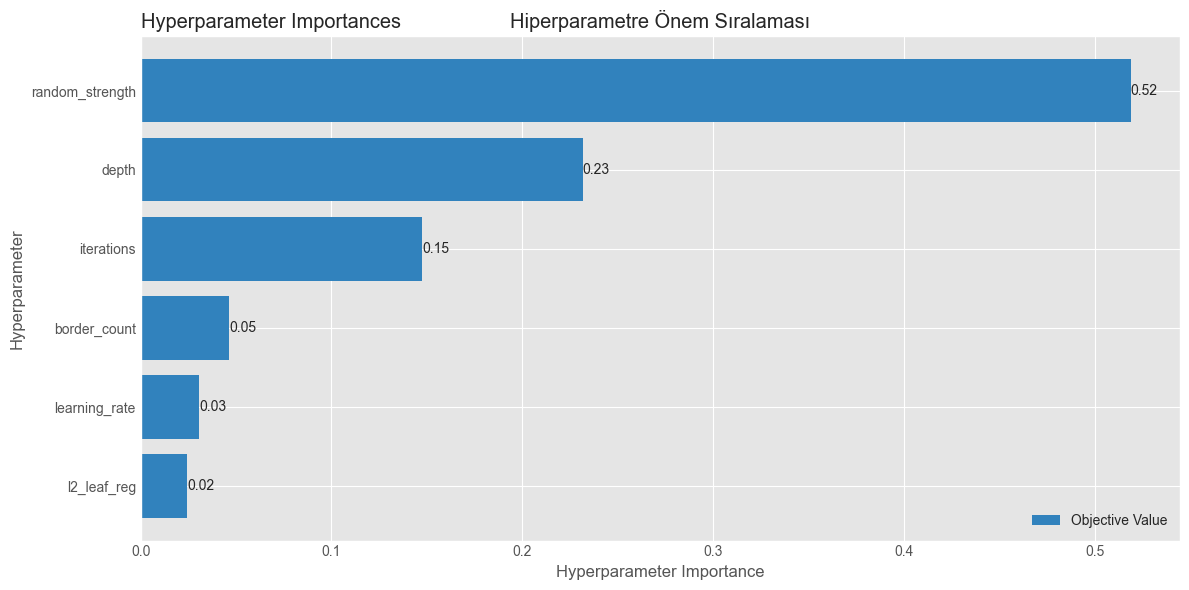

In [14]:
if OPTUNA_AVAILABLE:
    # Parametre önem grafiği
    try:
        from optuna.visualization.matplotlib import plot_param_importances
        
        fig = plot_param_importances(study)
        plt.title('Hiperparametre Önem Sıralaması')
        plt.tight_layout()
        plt.savefig('../outputs/figures/optuna_param_importance.png', dpi=150, bbox_inches='tight')
        plt.show()
    except:
        print("Parametre önem grafiği oluşturulamadı")

## 7. Final Model Eğitimi

En iyi parametrelerle final modeli eğitiyoruz.

In [15]:
# Final model parametreleri
final_params = {
    'iterations': best_params.get('iterations', 000),
    'learning_rate': best_params.get('learning_rate', 0.),
    'depth': best_params.get('depth', ),
    'l_leaf_reg': best_params.get('l_leaf_reg', .0),
    'border_count': best_params.get('border_count', ),
    'random_strength': best_params.get('random_strength', .0),
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': ,
    'early_stopping_rounds': 0,
    'verbose': 00,
    'cat_features': cat_feature_indices
}

print("Final Model Parametreleri:")
for param, value in final_params.items():
    if param != 'cat_features':
        print(f"{param}: {value}")

Final Model Parametreleri:
iterations: 
learning_rate: 0.0000
depth: 
l_leaf_reg: 0.000
border_count: 0
random_strength: .000
loss_function: RMSE
eval_metric: RMSE
random_seed: 
early_stopping_rounds: 0
verbose: 00


In [16]:
%%time

# Final modeli oluştur
model = CatBoostRegressor(**final_params)

print("Final model eğitimi başlıyor...")
print("=" * 0)

# Tüm eğitim verisiyle eğit (train + validation)
model.fit(
    X_train_full, y_train_full,
    eval_set=(X_test, y_test),
    use_best_model=True,
    plot=False
)

print("\n" + "=" * 0)
print("Model eğitimi tamamlandı!")
print(f"En iyi iterasyon: {model.get_best_iteration()}")

Final model eğitimi başlıyor...
0:	learn: 0.0	test: 0.	best: 0. (0)	total: .ms	remaining: .s
00:	learn: 0.0	test: 0.	best: 0. (00)	total: .s	remaining: 0.s
00:	learn: 0.	test: 0.0	best: 0.0 (00)	total: .s	remaining: .s
00:	learn: 0.	test: 0.0	best: 0.0 ()	total: 0.s	remaining: .s
00:	learn: 0.	test: 0.	best: 0. (00)	total: .s	remaining: .s
00:	learn: 0.00	test: 0.	best: 0.0 ()	total: .s	remaining: .s
00:	learn: 0.000	test: 0.0	best: 0.0 (00)	total: .s	remaining: .s
:	learn: 0.0	test: 0.0	best: 0. ()	total: .s	remaining: 0us
bestTest = 0.
bestIteration = 
Shrink model to first  iterations.
Model eğitimi tamamlandı!
En iyi iterasyon: 
CPU times: total: min s
Wall time: . s


## 8. Öğrenme Eğrileri (Learning Curves) 

Eğitim ve test hatasının iterasyonlar boyunca nasıl değiştiğini görselleştiriyoruz.

### Neden Önemli?
- **Overfitting tespiti**: Eğitim hatası düşerken test hatası artıyorsa overfitting var
- **Early stopping doğrulaması**: Doğru iterasyonda durduğumuzu gösterir
- **Öğrenme hızı analizi**: Learning rate çok yüksek/düşük mü?

In [17]:
# Öğrenme eğrilerini çizmek için model tekrar eğitilir (evals_result ile)
model_for_curves = CatBoostRegressor(
    iterations=final_params['iterations'],
    learning_rate=final_params['learning_rate'],
    depth=final_params['depth'],
    l_leaf_reg=final_params.get('l_leaf_reg', .0),
    loss_function='RMSE',
    random_seed=,
    verbose=0,
    cat_features=cat_feature_indices
)

# Pool oluştur
train_pool = Pool(X_train_full, y_train_full, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

# Eğit ve evals_result al
model_for_curves.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=0
)

# Eğitim geçmişini al
evals_result = model_for_curves.get_evals_result()

print("Öğrenme eğrileri için model eğitildi")

Öğrenme eğrileri için model eğitildi


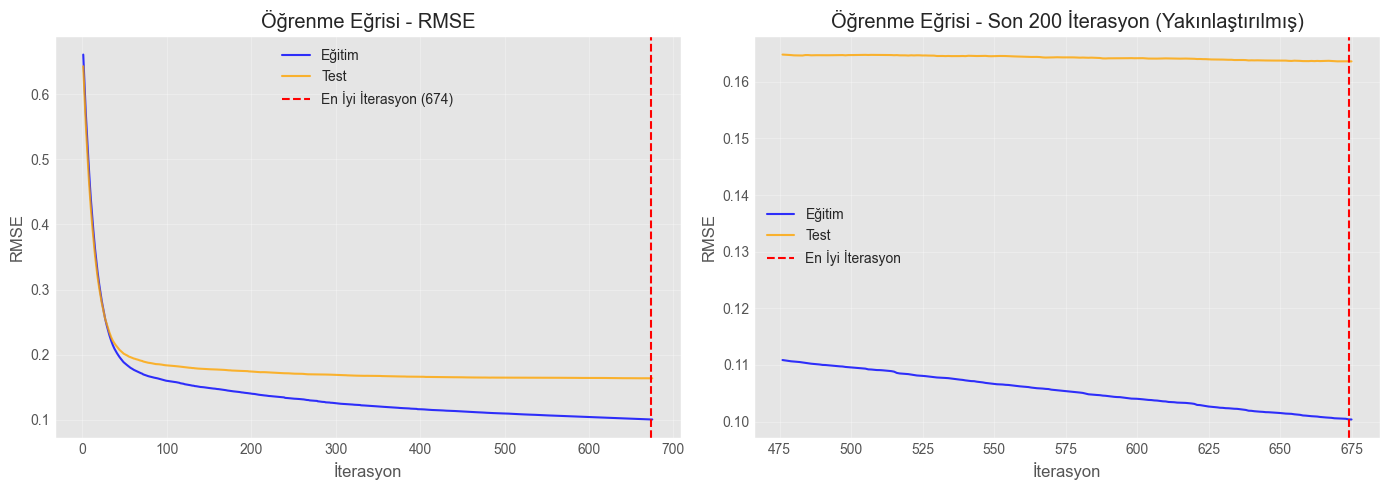

Öğrenme Eğrisi Analizi:
Son eğitim RMSE  : 0.00
Son test RMSE    : 0.
En iyi test RMSE : 0. (İterasyon )
Train-Test RMSE farkı (0.0) makul - overfitting yok


In [18]:
# Öğrenme eğrileri grafiği
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE eğrileri
train_rmse = evals_result['learn']['RMSE']
test_rmse = evals_result['validation']['RMSE']
iterations = range(, len(train_rmse) + )

axes[0].plot(iterations, train_rmse, label='Eğitim', color='blue', alpha=0.)
axes[0].plot(iterations, test_rmse, label='Test', color='orange', alpha=0.)
axes[0].axvline(x=model_for_curves.get_best_iteration(), color='red', linestyle='--', 
                label=f'En İyi İterasyon ({model_for_curves.get_best_iteration()})')
axes[0].set_xlabel('İterasyon')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Öğrenme Eğrisi - RMSE')
axes[0].legend()
axes[0].grid(True, alpha=0.)

# Yakınlaştırılmış görünüm (son 00 iterasyon)
start_idx = max(0, len(train_rmse) - 00)
axes[1].plot(iterations[start_idx:], train_rmse[start_idx:], label='Eğitim', color='blue', alpha=0.)
axes[1].plot(iterations[start_idx:], test_rmse[start_idx:], label='Test', color='orange', alpha=0.)
if model_for_curves.get_best_iteration() > start_idx:
    axes[1].axvline(x=model_for_curves.get_best_iteration(), color='red', linestyle='--', 
                    label=f'En İyi İterasyon')
axes[1].set_xlabel('İterasyon')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Öğrenme Eğrisi - Son 00 İterasyon (Yakınlaştırılmış)')
axes[1].legend()
axes[1].grid(True, alpha=0.)

plt.tight_layout()
plt.savefig('../outputs/figures/learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Analiz
print("Öğrenme Eğrisi Analizi:")
print(f"Son eğitim RMSE  : {train_rmse[-]:.f}")
print(f"Son test RMSE    : {test_rmse[-]:.f}")
print(f"En iyi test RMSE : {min(test_rmse):.f} (İterasyon {test_rmse.index(min(test_rmse)) + })")

# Overfitting kontrolü
gap = test_rmse[-] - train_rmse[-]
if gap > 0.:
    print(f"\n Dikkat: Train-Test RMSE farkı ({gap:.f}) yüksek - hafif overfitting olabilir")
else:
    print(f"\n Train-Test RMSE farkı ({gap:.f}) makul - overfitting yok")

## 9. Model Değerlendirme

In [19]:
# Tahmin yap
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test)

# Log dönüşümünü geri al (eğer log hedef kullandıysak)
if USE_LOG_TARGET:
    y_train_actual = np.expm(y_train_full)
    y_test_actual = np.expm(y_test)
    y_train_pred_actual = np.expm(y_train_pred)
    y_test_pred_actual = np.expm(y_test_pred)
else:
    y_train_actual = y_train_full
    y_test_actual = y_test
    y_train_pred_actual = y_train_pred
    y_test_pred_actual = y_test_pred

In [20]:
def evaluate_model(y_true, y_pred, set_name=""):
    """
    Model performans metriklerini hesaplar.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 00
    
    print(f"{set_name} Performansı:")
    print(f"MAE  : {mae:,.0f} TL")
    print(f"RMSE : {rmse:,.0f} TL")
    print(f"R²   : {r:.f}")
    print(f"MAPE : {mape:.f}%")
    
    return {'mae': mae, 'rmse': rmse, 'r': r, 'mape': mape}

print("=" * 0)
train_metrics = evaluate_model(y_train_actual, y_train_pred_actual, "Eğitim Seti")
print()
test_metrics = evaluate_model(y_test_actual, y_test_pred_actual, "Test Seti")
print("=" * 0)

Eğitim Seti Performansı:
MAE  : , TL
RMSE : ,0 TL
R²   : 0.0
MAPE : .%
Test Seti Performansı:
MAE  : , TL
RMSE : ,00 TL
R²   : 0.0
MAPE : 0.%


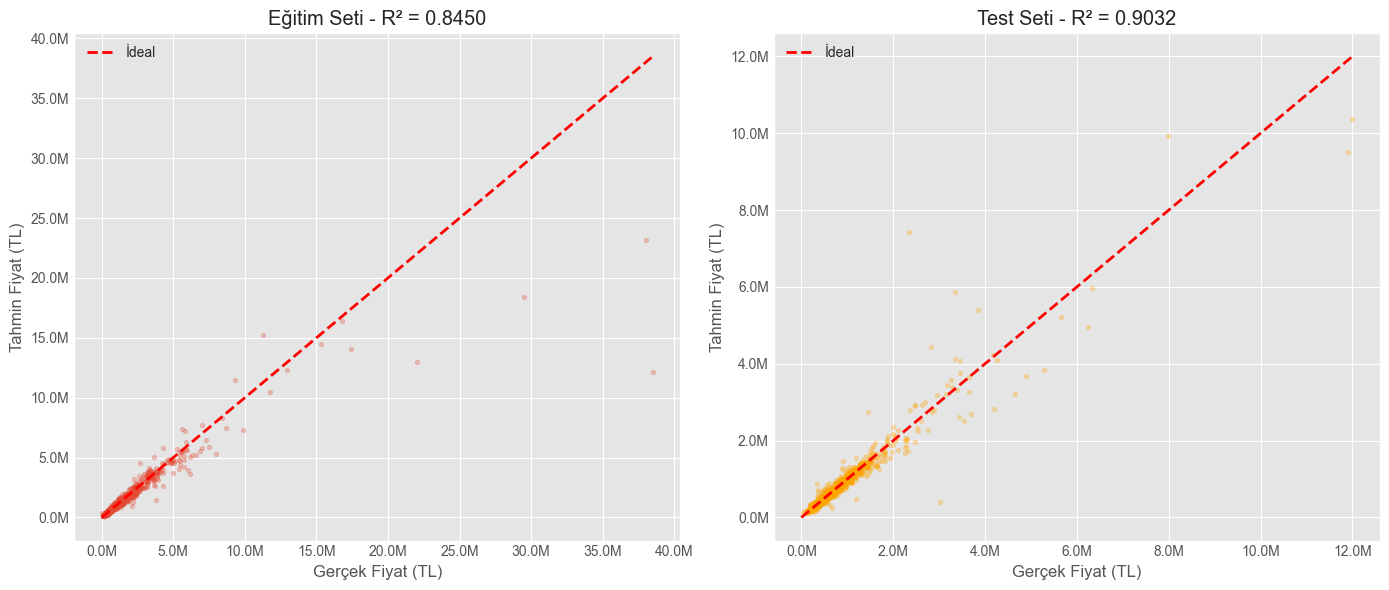

In [21]:
# Gerçek vs Tahmin grafiği
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Eğitim seti
axes[0].scatter(y_train_actual, y_train_pred_actual, alpha=0.5, s=30)
max_val = max(y_train_actual.max(), y_train_pred_actual.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=, label='İdeal')
axes[0].set_xlabel('Gerçek Fiyat (TL)')
axes[0].set_ylabel('Tahmin Fiyat (TL)')
axes[0].set_title(f'Eğitim Seti - R² = {train_metrics["r"]:.f}')
axes[0].legend()
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/e:.f}M'))
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/e:.f}M'))

# Test seti
axes[1].scatter(y_test_actual, y_test_pred_actual, alpha=0.5, s=0, color='orange')
max_val = max(y_test_actual.max(), y_test_pred_actual.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', lw=, label='İdeal')
axes[1].set_xlabel('Gerçek Fiyat (TL)')
axes[1].set_ylabel('Tahmin Fiyat (TL)')
axes[1].set_title(f'Test Seti - R² = {test_metrics["r"]:.f}')
axes[1].legend()
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/e:.f}M'))
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/e:.f}M'))

plt.tight_layout()
plt.savefig('../outputs/figures/model_gercek_vs_tahmin.png', dpi=150, bbox_inches='tight')
plt.show()

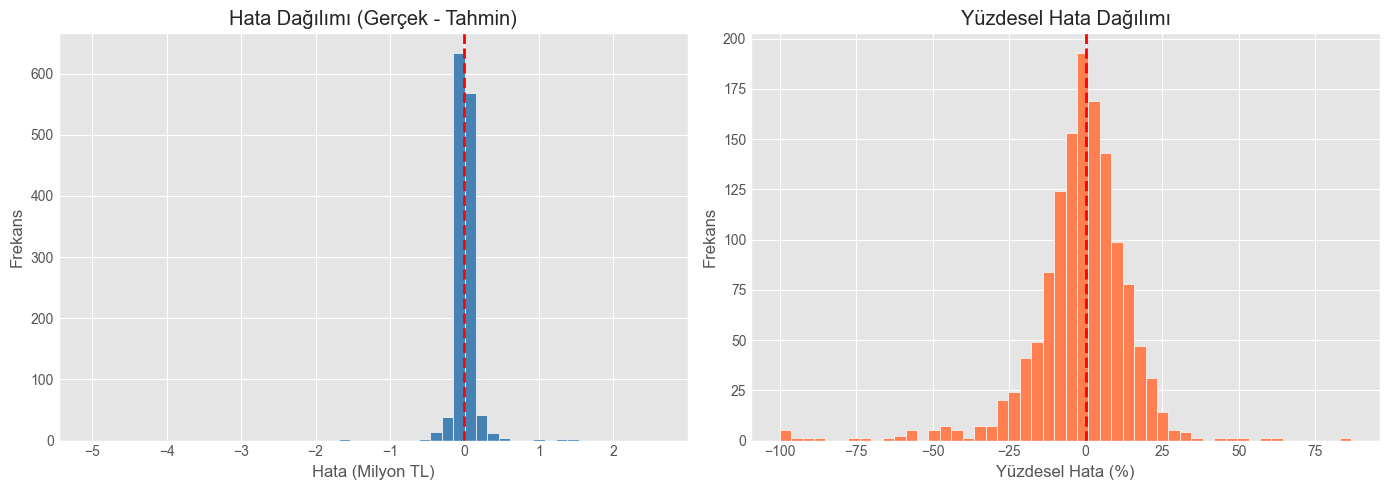

Hata İstatistikleri:
Ortalama hata: -00 TL
Medyan hata: -,0 TL
Std hata: ,0 TL


In [22]:
# Hata dağılımı
errors = y_test_actual - y_test_pred_actual
error_percent = (errors / y_test_actual) * 00

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mutlak hata dağılımı
axes[0].hist(errors/e, bins=50, color='steelblue', edgecolor='white')
axes[0].axvline(x=0, color='red', linestyle='--', lw=)
axes[0].set_xlabel('Hata (Milyon TL)')
axes[0].set_ylabel('Frekans')
axes[0].set_title('Hata Dağılımı (Gerçek - Tahmin)')

# Yüzdesel hata dağılımı
axes[1].hist(error_percent.clip(-00, 00), bins=50, color='coral', edgecolor='white')
axes[1].axvline(x=0, color='red', linestyle='--', lw=)
axes[1].set_xlabel('Yüzdesel Hata (%)')
axes[1].set_ylabel('Frekans')
axes[1].set_title('Yüzdesel Hata Dağılımı')

plt.tight_layout()
plt.savefig('../outputs/figures/model_hata_dagilimi.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Hata İstatistikleri:")
print(f"Ortalama hata: {errors.mean():,.0f} TL")
print(f"Medyan hata: {errors.median():,.0f} TL")
print(f"Std hata: {errors.std():,.0f} TL")

## 10. Özellik Önem Analizi

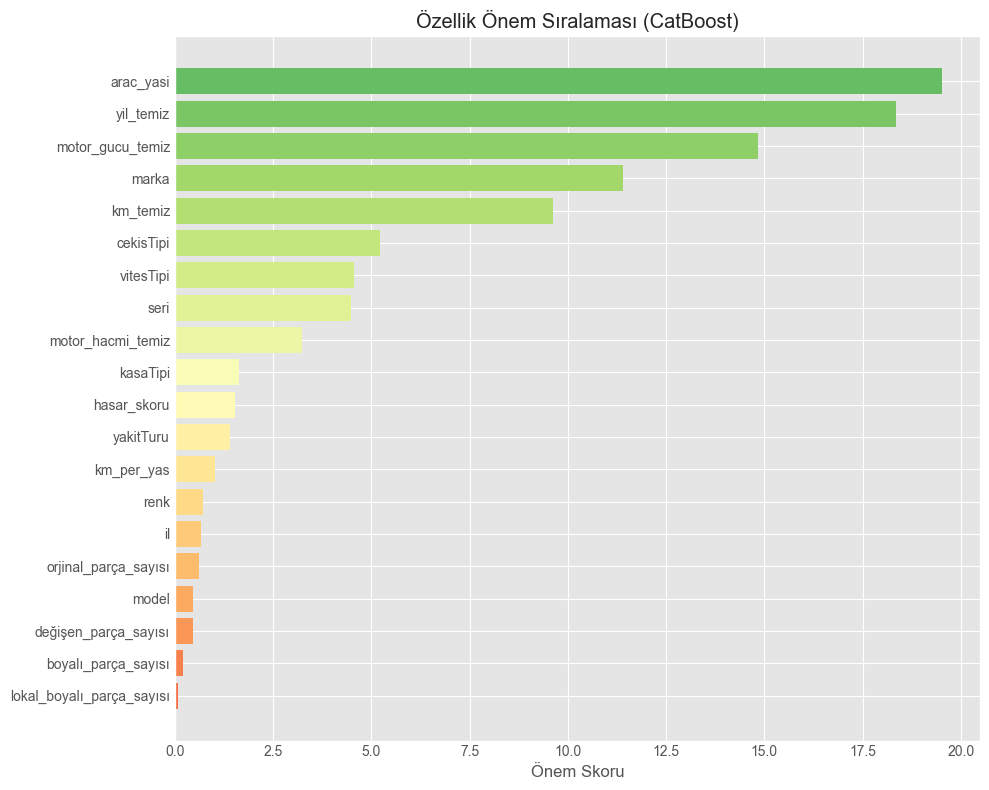

En Önemli 0 Özellik:
Özellik      Önem
kasaTipi  .
motor_hacmi_temiz  .
seri  .0
vitesTipi  .
cekisTipi  .
km_temiz  .0
marka .
motor_gucu_temiz .0
yil_temiz .0
arac_yasi .


In [23]:
# Özellik önemlerini al
feature_importance = model.get_feature_importance()
feature_names = X.columns.tolist()

# DataFrame oluştur ve sırala
importance_df = pd.DataFrame({
    'Özellik': feature_names,
    'Önem': feature_importance
}).sort_values('Önem', ascending=True)

# Görselleştir
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.RdYlGn(np.linspace(0., 0., len(importance_df)))
ax.barh(importance_df['Özellik'], importance_df['Önem'], color=colors)
ax.set_xlabel('Önem Skoru')
ax.set_title('Özellik Önem Sıralaması (CatBoost)')

plt.tight_layout()
plt.savefig('../outputs/figures/ozellik_onem.png', dpi=150, bbox_inches='tight')
plt.show()

# En önemli 0 özellik
print("En Önemli 0 Özellik:")
print(importance_df.tail(0).to_string(index=False))

## 11. Cross-Validation

In [24]:
# K-Fold Cross Validation
print("-Fold Cross Validation yapılıyor...")

kfold = KFold(n_splits=, shuffle=True, random_state=)

cv_scores = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X), ):
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Model eğit (en iyi parametrelerle)
    fold_model = CatBoostRegressor(
        iterations=final_params.get('iterations', 00),
        learning_rate=final_params.get('learning_rate', 0.),
        depth=final_params.get('depth', ),
        l_leaf_reg=final_params.get('l_leaf_reg', .0),
        random_seed=,
        verbose=0,
        cat_features=cat_feature_indices
    )
    
    fold_model.fit(X_fold_train, y_fold_train)
    
    # Tahmin ve değerlendirme
    y_fold_pred = fold_model.predict(X_fold_val)
    
    if USE_LOG_TARGET:
        y_fold_val_actual = np.expm(y_fold_val)
        y_fold_pred_actual = np.expm(y_fold_pred)
    else:
        y_fold_val_actual = y_fold_val
        y_fold_pred_actual = y_fold_pred
    
    r = r2_score(y_fold_val_actual, y_fold_pred_actual)
    mae = mean_absolute_error(y_fold_val_actual, y_fold_pred_actual)
    
    cv_scores.append({'fold': fold, 'r': r, 'mae': mae})
    print(f"Fold {fold}: R² = {r:.f}, MAE = {mae:,.0f} TL")

cv_df = pd.DataFrame(cv_scores)
print(f"\n Cross-Validation Sonuçları:")
print(f"Ortalama R²  : {cv_df['r'].mean():.f} ± {cv_df['r'].std():.f}")
print(f"Ortalama MAE : {cv_df['mae'].mean():,.0f} ± {cv_df['mae'].std():,.0f} TL")

-Fold Cross Validation yapılıyor...
Fold : R² = 0., MAE = , TL
Fold : R² = 0.0, MAE = , TL
Fold : R² = 0.000, MAE = ,0 TL
Fold : R² = 0., MAE = 0, TL
Fold : R² = 0., MAE = ,0 TL
Cross-Validation Sonuçları:
Ortalama R²  : 0. ± 0.
Ortalama MAE : 0, ± 0,0 TL


## 12. Model Kaydetme

In [25]:
# Modeli kaydet
model.save_model('../outputs/models/catboost_fiyat_model.cbm')
print("Model kaydedildi: outputs/models/catboost_fiyat_model.cbm")

# Model metadata'sını kaydet
model_meta = {
    'model_type': 'CatBoostRegressor',
    'features': ALL_FEATURES,
    'categorical_features': cat_features_available,
    'numerical_features': num_features_available,
    'target': TARGET,
    'use_log_target': USE_LOG_TARGET,
    'best_iteration': model.get_best_iteration(),
    'hyperparameters': {
        'iterations': final_params.get('iterations'),
        'learning_rate': final_params.get('learning_rate'),
        'depth': final_params.get('depth'),
        'l_leaf_reg': final_params.get('l_leaf_reg')
    },
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'cv_r_mean': cv_df['r'].mean(),
    'cv_r_std': cv_df['r'].std(),
    'cv_mae_mean': cv_df['mae'].mean(),
    'cv_mae_std': cv_df['mae'].std(),
    'optuna_used': OPTUNA_AVAILABLE
}

with open('../outputs/models/model_meta.json', 'w', encoding='utf-8') as f:
    json.dump(model_meta, f, ensure_ascii=False, indent=2, default=float)

print("Model metadata kaydedildi: outputs/models/model_meta.json")

Model kaydedildi: outputs/models/catboost_fiyat_model.cbm
Model metadata kaydedildi: outputs/models/model_meta.json


In [26]:
# Özellik önemlerini kaydet
importance_df.to_csv('../outputs/models/feature_importance.csv', index=False)
print("Özellik önemleri kaydedildi: outputs/models/feature_importance.csv")

Özellik önemleri kaydedildi: outputs/models/feature_importance.csv


## Örnek Tahminler

In [27]:
# Rastgele  örnek seç ve tahmin yap
sample_indices = np.random.choice(X_test.index, , replace=False)

print("Örnek Tahminler:")
print("=" * 0)

for idx in sample_indices:
    sample = X_test.loc[[idx]]
    actual_price = y_test_actual.loc[idx] if USE_LOG_TARGET else y_test.loc[idx]
    
    pred_log = model.predict(sample)[0]
    pred_price = np.expm(pred_log) if USE_LOG_TARGET else pred_log
    
    error_percent = ((pred_price - actual_price) / actual_price) * 00
    
    print(f"\n {sample['marka'].values[0]} {sample['model'].values[0]} ({sample['yil_temiz'].values[0]:.0f})")
    print(f"KM: {sample['km_temiz'].values[0]:,.0f}")
    print(f"Gerçek Fiyat : {actual_price:,.0f} TL")
    print(f"Tahmin Fiyat : {pred_price:,.0f} TL")
    print(f"Hata         : {error_percent:+.f}%")

Örnek Tahminler:
Toyota . Elegant Extra (0)
KM: ,000
Gerçek Fiyat : 0,000 TL
Tahmin Fiyat : , TL
Hata         : +0.%
Audi A Sportback . TFSI Ambition (00)
KM: ,000
Gerçek Fiyat : 0,000 TL
Tahmin Fiyat : , TL
Hata         : +.%
Peugeot . PureTech GT (0)
KM: ,000
Gerçek Fiyat : ,,000 TL
Tahmin Fiyat : ,, TL
Hata         : -.%
Audi A Sedan . TFSI Dynamic (0)
KM: ,000
Gerçek Fiyat : ,0,000 TL
Tahmin Fiyat : ,,0 TL
Hata         : +.%
Peugeot XR ()
KM: 0,000
Gerçek Fiyat : ,000 TL
Tahmin Fiyat : 0,0 TL
Hata         : +.0%


## Özet

### Model Performansı

In [28]:
print("="*80)
print("MODEL PERFORMANS ÖZETİ")
print("="*80)
print(f"\n Model: CatBoost Regressor")
print(f"Özellik Sayısı: {len(ALL_FEATURES)}")
print(f"- Kategorik: {len(cat_features_available)}")
print(f"- Sayısal: {len(num_features_available)}")

print(f"\n Hiperparametreler:")
print(f"- iterations: {final_params.get('iterations')}")
print(f"- learning_rate: {final_params.get('learning_rate')}")
print(f"- depth: {final_params.get('depth')}")
print(f"- l_leaf_reg: {final_params.get('l_leaf_reg')}")
if OPTUNA_AVAILABLE:
    print(f"Optuna ile optimize edildi")

print(f"\n Test Seti Performansı:")
print(f"R² Score : {test_metrics['r']:.f}")
print(f"MAE      : {test_metrics['mae']:,.0f} TL")
print(f"RMSE     : {test_metrics['rmse']:,.0f} TL")
print(f"MAPE     : {test_metrics['mape']:.f}%")

print(f"\n Cross-Validation (-Fold):")
print(f"R² : {cv_df['r'].mean():.f} ± {cv_df['r'].std():.f}")
print(f"MAE: {cv_df['mae'].mean():,.0f} ± {cv_df['mae'].std():,.0f} TL")

print(f"\n Kaydedilen Dosyalar:")
print(f"- outputs/models/catboost_fiyat_model.cbm")
print(f"- outputs/models/model_meta.json")
print(f"- outputs/models/feature_importance.csv")
print(f"- outputs/figures/learning_curves.png")
print(f"- outputs/figures/optuna_param_importance.png (Optuna varsa)")
print("="*80)

MODEL PERFORMANS ÖZETİ
Model: CatBoost Regressor
Özellik Sayısı: 0
- Kategorik: 
- Sayısal: 
Hiperparametreler:
- iterations: 
- learning_rate: 0.0000
- depth: 
- l_leaf_reg: 0.000
Optuna ile optimize edildi
Test Seti Performansı:
R² Score : 0.0
MAE      : , TL
RMSE     : ,00 TL
MAPE     : 0.%
Cross-Validation (-Fold):
R² : 0. ± 0.
MAE: 0, ± 0,0 TL
Kaydedilen Dosyalar:
- outputs/models/catboost_fiyat_model.cbm
- outputs/models/model_meta.json
- outputs/models/feature_importance.csv
- outputs/figures/learning_curves.png
- outputs/figures/optuna_param_importance.png (Optuna varsa)
